# <center>Minimum Transformation Method
## <center>An inverse model for inferring surface fluxes and mixing from gridded hydrographic TS data, <br> by Taimoor Sohail and Jan D. Zika



##### <center>We use an optimal transport method, minimzing a cost function which respects the volume and mass conservation, and the fundamental physics of mixing in TS space. <br>See also: Jan D Zika et al. (2021) [www.doi.org/10.1175/JCLI-D-20-0355.1 ] for a simpler version of this model which optimizes ocean circulation only.
------------

### __The code is laid out as follows:__
#### A) Pre-processing
i) Load necessary modules for computation \
ii) Define key parameters
#### B) Load Data
#### C) Define constraints
i) Define Connectivity \
ii) Define weights
#### D) Run optimisation
#### E) Save Output
---------

## A) Pre-processing

### i) Load necessary modules for computation

In [1]:
## Module to run the minimisation
from WM_Methods import MTM
## Module to track runtime of cells and loops
import time
from tqdm.notebook import tqdm
## Suppress warnings related to division by zero
import warnings
warnings.filterwarnings('ignore')
## Module to load files and handle array computations
import xarray as xr
import numpy as np
## Modules to plot outputs
import matplotlib.pyplot as plt
import matplotlib.patches as patches
# Specify font properties for plots
# from matplotlib import rc
# font = {'family' : 'DejaVu Sans',
#         'weight' : 'normal',
#         'size'   : 16}

# rc('font', **font)

### ii) Define key parameters

In [2]:
# Thermal expansion, haline contraction and true scale factor
alph = 1.7657*10**-4
bet = 7.5544*10**-4

volnorming = 10**15 #normalising coeffcients
areanorming = 10**12 #normalising coeffcients
ST_scale=bet/alph

# Establish basic constants 
yr2sec = 365.25*24*60*60
Cp=4000
rho=1024
S0=35

# If Surface fluxes are available
SF = True
# To run the optimisation twice 
Opt_twice = False

# Range of years of which 'early' and 'late' are defined

if SF:
    ## ERA5 begins in 1979 so we have to change our "early" and "late" periods
    dyrs = 2014-1979+1
    init_early = 1979
    init_late = 1979
    Early_period = (np.array([init_early,init_early+dyrs]) - init_early)*12
    Late_period = (np.array([init_late,init_late+dyrs]) - init_early)*12
    range_yrs = init_late-init_early+1

else:
    dyrs = 9
    init_early = 1979
    init_late = 2006
    Early_period = (np.array([init_early,init_early+dyrs]) - init_early)*12
    Late_period = (np.array([init_late,init_late+dyrs]) - init_early)*12
    range_yrs = init_late-init_early+1




-----------
## B) Load Data



The data is presented as monthly T-S observations from EN4, from January 1970 to December 2014. The observations have already been binned via Binary Space Partitioning according to a specific criterion. Folowing Sohail et al. (TBD) the BSP partitioning occurs in an xyxyxyx order, shown to minimize variability in the temperature and salinity signals. 



In [3]:
%%time
if SF:
    ERA5_BSP_data = xr.open_mfdataset('BSP_processed/BSP_ERA5_TS_*.nc')
    
    ## Early Period
    Part_early = ERA5_BSP_data.Partitions.isel(Time=slice(Early_period[0],Early_period[1])).mean('Time')
    SA_early =  ERA5_BSP_data.S_mean.isel(Time=slice(Early_period[0],Early_period[1])).mean('Time')
    CT_early = ERA5_BSP_data.T_mean.isel(Time=slice(Early_period[0],Early_period[1])).mean('Time')
    V_early = ERA5_BSP_data.V_sum.isel(Time=slice(Early_period[0],Early_period[1])).mean('Time')
    A_early = ERA5_BSP_data.A_sum.isel(Time=slice(Early_period[0],Early_period[1])).mean('Time')

    ## Late Period
    Part_late = ERA5_BSP_data.Partitions.isel(Time=slice(Late_period[0],Late_period[1])).mean('Time')
    SA_late =  ERA5_BSP_data.S_mean.isel(Time=slice(Late_period[0],Late_period[1])).mean('Time')
    CT_late = ERA5_BSP_data.T_mean.isel(Time=slice(Late_period[0],Late_period[1])).mean('Time')
    V_late = ERA5_BSP_data.V_sum.isel(Time=slice(Late_period[0],Late_period[1])).mean('Time')
    A_late = ERA5_BSP_data.A_sum.isel(Time=slice(Late_period[0],Late_period[1])).mean('Time')

    Basins = ERA5_BSP_data.Basin.values
else:
    EN4_BSP_data = xr.open_mfdataset('BSP_processed/BSP_EN4_TS_*.nc')

    ## Early Period
    Part_early = EN4_BSP_data.Partitions.isel(Time=slice(Early_period[0],Early_period[1])).mean('Time')
    SA_early =  EN4_BSP_data.S_mean.isel(Time=slice(Early_period[0],Early_period[1])).mean('Time')
    CT_early = EN4_BSP_data.T_mean.isel(Time=slice(Early_period[0],Early_period[1])).mean('Time')
    V_early = EN4_BSP_data.V_sum.isel(Time=slice(Early_period[0],Early_period[1])).mean('Time')
    A_early = EN4_BSP_data.A_sum.isel(Time=slice(Early_period[0],Early_period[1])).mean('Time')


    ## Late Period
    Part_late = EN4_BSP_data.Partitions.isel(Time=slice(Late_period[0],Late_period[1])).mean('Time')
    SA_late =  EN4_BSP_data.S_mean.isel(Time=slice(Late_period[0],Late_period[1])).mean('Time')
    CT_late = EN4_BSP_data.T_mean.isel(Time=slice(Late_period[0],Late_period[1])).mean('Time')
    V_late = EN4_BSP_data.V_sum.isel(Time=slice(Late_period[0],Late_period[1])).mean('Time')
    A_late = EN4_BSP_data.A_sum.isel(Time=slice(Late_period[0],Late_period[1])).mean('Time')

    Basins = EN4_BSP_data.Basin.values

CPU times: user 3.53 s, sys: 252 ms, total: 3.78 s
Wall time: 5.59 s


In [4]:
## Load ERA5 data here, if provided
if SF:
    time = ERA5_BSP_data.Time.values
    ## Calculate the time-mean hfds and wfo
    dhfds = ERA5_BSP_data.hfds_sum.mean('Time')*(1/(24*3600)) # units: W
    dwfo = ERA5_BSP_data.wfo_sum.mean('Time') # units: kg/s

    ## Convert dflux to equivalent T or S change
    dT_hfds = dhfds/(Cp*rho*V_early)*yr2sec # units: C/yr
    dS_wfo = -dwfo*S0/(rho*V_early)*yr2sec # units: g/kg/yr

In [5]:

# Flatten the early and late variables to a 1D array
Vol_1 = V_early.values.flatten()
Vol_2 = V_late.values.flatten()
S_1 = SA_early.values.flatten()-S0 # Remove reference salinity S0
S_2 = SA_late.values.flatten()-S0 # Remove reference salinity S0
T_1 = CT_early.values.flatten()
T_2 = CT_late.values.flatten()
A_1 = A_early.values.flatten()
A_2 = A_late.values.flatten()

# Do the same for basin index
Basin_1 = np.zeros_like(V_early)
Basin_2 = np.zeros_like(V_early)
Basin_names = []
for i in range(np.array(Basins).size):
    Basin_1[i,:] = i
    Basin_2[i,:] = i
    for j in range(V_early.shape[-1]):
        #... and for basin name
        Basin_names.append(Basins[i])

Basin_1_inds = Basin_1.flatten()
Basin_2_inds = Basin_2.flatten()

#... and for the edges of the BSP bins
## Here we calculate the mean TS edges averaged over both early and late times
S_start = (0.5*(Part_early.values[:,:,0]+Part_late.values[:,:,0])).flatten()-S0 # Remove reference salinity S0
S_end = (0.5*(Part_early.values[:,:,1]+Part_late.values[:,:,1])).flatten()-S0 # Remove reference salinity S0
T_start = (0.5*(Part_early.values[:,:,2]+Part_late.values[:,:,2])).flatten()
T_end = (0.5*(Part_early.values[:,:,3]+Part_late.values[:,:,3])).flatten()

# Any NaNs are zeroed out
S_1[np.isnan(S_1)] = 0
S_2[np.isnan(S_2)] = 0
T_1[np.isnan(T_1)] = 0
T_2[np.isnan(T_2)] = 0

In [6]:
## IF SURFACE FLUXES ARE PROVIDED -- add here ##
if SF:
    S_pre = SA_early.values.flatten()-S0
    S_1 = SA_early.values.flatten()-S0+dS_wfo.values.flatten()
    T_pre = CT_early.values.flatten()
    T_1 = CT_early.values.flatten()+dT_hfds.values.flatten()

    S_1[np.isnan(S_1)] = 0
    T_1[np.isnan(T_1)] = 0
    S_1[~np.isfinite(S_1)] = 0
    T_1[~np.isfinite(T_1)] = 0


In [7]:
## Here, we create the tracers and volumes matrices, which will be fed into the MTM function

volumes = np.stack((Vol_1, Vol_2), axis=0)/volnorming # Shape: [2 x N]

salinities = np.stack((S_1, S_2), axis=0)
temps = np.stack((T_1, T_2), axis=0)

tracers = np.stack((salinities, temps),axis=1) # Shape: [2 x M x N], where M = 2 for just T and S, and M>2 for T,S+other tracers

In [8]:
print('Total number of bins =', int(Vol_1.shape[0]))
N = int(Vol_1.shape[0])

Total number of bins = 1152


---------------
## C) Define Constraints

### i) Define Connectivity

We must define whether a BSP bin is allowed to transport volume to another BSP bin. In the simplest case, all bins are allowed to transport to one another - but this yields nonphysical transport across vast distances and TS bounds.
To improve on this, two connectivity constraints are used: 
1) Are the basins adjacent? This is defined via the connectivity array, below
2) If YES, do the BSP bins have overlapping (or the same) TS boundaries?\
If yes, the bins are connected. If no, they are not.


In [9]:
# Array defining the connection between the 9 basins;
# 1 = connected, 0 = disconnected
connectivity_array = np.zeros((Basins.size,Basins.size))

connectivity_array[0,:] = [1, 1, 0, 0, 0, 0, 0, 0, 0]
connectivity_array[1,:] = [1, 1, 1, 0, 0, 0, 0, 0, 0]
connectivity_array[2,:] = [0, 1, 1, 1, 0, 0, 0, 0, 0]
connectivity_array[3,:] = [0, 0, 1, 1, 0, 0, 0, 0, 1]
connectivity_array[4,:] = [0, 0, 0, 0, 1, 0, 1, 0, 1]
connectivity_array[5,:] = [0, 0, 0, 0, 0, 1, 1, 0, 1]
connectivity_array[6,:] = [0, 0, 0, 0, 1, 1, 1, 1, 0]
connectivity_array[7,:] = [0, 0, 0, 0, 0, 0, 1, 1, 0]
connectivity_array[8,:] = [0, 0, 0, 1, 1, 1, 0, 0, 1]

# Array defining the transport between the 9 basins;
# +/-1 = connected (North = +, East = +), 0 = no constraint
transport_array = np.zeros((Basins.size,Basins.size))
transport_array2 = np.zeros((Basins.size,Basins.size))

transport_array[4,:] = [0, 0, 0, 0, 0, 0, 1, 0, 0]
transport_array[6,:] = [0, 0, 0, 0, -1, 0, 0, 0, 0]

transport_array2[0,:] = [0, 1, 0, 0, 0, 0, 0, 0, 0]

print(170/volnorming*(0.5*yr2sec*10**6))

2.6823960000000002


In [10]:
# Define whether a bin is connected to every other bin
# The two constraints used are: are the basins adjacent? 
# If yes, are the bin indices the same? 
# If yes, the bins are connected; if no, they are not connected. 
connected = np.zeros((Vol_1.size, Vol_1.size))
trans_big = np.zeros((Vol_1.size, Vol_1.size))
trans_big2 = np.zeros((Vol_1.size, Vol_1.size))

for i in tqdm(range(Vol_1.size)):
    for j in range(Vol_2.size):
        trans_big[i,j] = transport_array[int(Basin_1_inds[i]), int(Basin_2_inds[j])]
        trans_big2[i,j] = transport_array2[int(Basin_1_inds[i]), int(Basin_2_inds[j])]
        if connectivity_array[int(Basin_1_inds[i]), int(Basin_2_inds[j])]>0:
                if Basin_names[i] == Basin_names[j]:
                    connected[i,j] = connectivity_array[int(Basin_1_inds[i]), int(Basin_2_inds[j])]
                elif S_start[i]==S_start[j] and T_start[i]==T_start[j]:
                    connected[i,j] = connectivity_array[int(Basin_1_inds[i]), int(Basin_2_inds[j])]

constraints = connected # Shape: An [N x N] matrix

transport = trans_big
transport2 = trans_big2

  0%|          | 0/1152 [00:00<?, ?it/s]

### ii) Define Weights

In [11]:
## We create a weight matrix
# Note that the code is very sensitive to the weights we input, and may break (TO BE DEVELOPED)
offset = 10**10 # To prevent divide by zero errors
# Mask where 1/A = inf
# area_weight = np.ones_like(A_2)
area_weight = np.log10(areanorming)/(np.log10(A_2))
area_weight[area_weight==0] = 10
# print(ST_scale)
weights = np.stack((ST_scale*area_weight,area_weight), axis=0) # Shape: An [M x N] matrix
# weights = np.ones_like(weights)

-----------------
## D) Run Optimisation

In [12]:
## We run the optimiser to get the transports between water masses and the T,S mixed and T,S adjustment
result = MTM.optimise(tracers, volumes, constraints, transport, transport2, weights)

g_ij = result['g_ij'] ## An [N x N] matrix of transports between WMs
Mixing = result['Mixing'] ## An [M x N] matrix of dtracer mixing for each WM
Adjustment = result['Adjustment'] ## An [M x N] matrix of dtracer adjustment for each WM

                                     CVXPY                                     
                                    v1.1.13                                    
(CVXPY) Jun 21 11:12:09 AM: Your problem has 149760 variables, 3 constraints, and 0 parameters.
(CVXPY) Jun 21 11:12:11 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jun 21 11:12:11 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jun 21 11:12:11 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jun 21 11:12:11 AM: Compiling problem (target solver=MOSEK).
(CVXPY) Jun 21 11:12:11 AM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffi

In [13]:
print(np.nansum(g_ij.flatten()*transport2.flatten()))
print(85/volnorming*(yr2sec*10**6))

5.389147218562966
2.6823960000000002


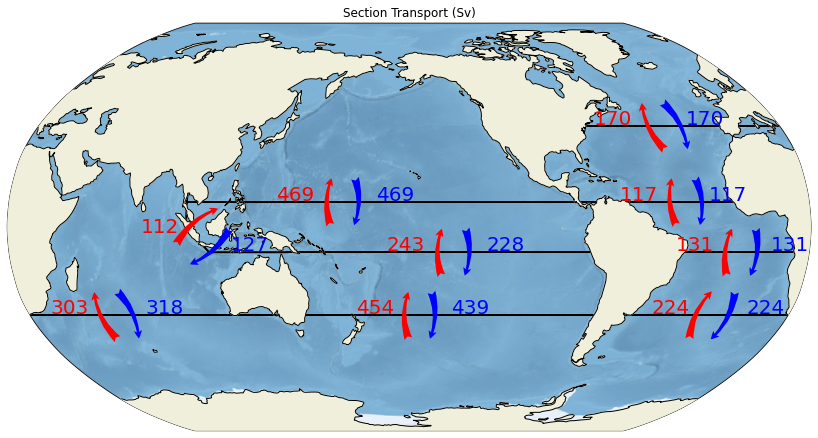

In [14]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import gridspec

# Array defining the connection between the 9 basins;
# 1 = connected (sign convention: North = +, East = +), 0 = disconnected
connectivity_array = np.zeros((Basins.size,Basins.size))

connectivity_array[0,:] = [1, -1, 0, 0, 0, 0, 0, 0, 0]
connectivity_array[1,:] = [1, 1, -1, 0, 0, 0, 0, 0, 0]
connectivity_array[2,:] = [0, 1, 1, -1, 0, 0, 0, 0, 0]
connectivity_array[3,:] = [0, 0, 1, 1, 0, 0, 0, 0, -1]
connectivity_array[4,:] = [0, 0, 0, 0, 1, 0, 1, 0, -1]
connectivity_array[5,:] = [0, 0, 0, 0, 0, 1, 1, 0, -1]
connectivity_array[6,:] = [0, 0, 0, 0, -1, -1, 1, 1, 0]
connectivity_array[7,:] = [0, 0, 0, 0, 0, 0, -1, 1, 0]
connectivity_array[8,:] = [0, 0, 0, 1, 1, 1, 0, 0, 1]

section_trans = np.ones((Vol_1.size,Vol_1.size))*0
for i in (range(Vol_1.size)):
    for j in range(Vol_2.size):
        if connectivity_array[int(Basin_1_inds[i]), int(Basin_2_inds[j])]!=0:
            if Basin_names[i] != Basin_names[j]:
                section_trans[i,j] = g_ij[i,j]*connectivity_array[int(Basin_1_inds[i]), int(Basin_2_inds[j])]/(yr2sec*10**6)*volnorming

int_section_trans = np.zeros((Basins.size, Basins.size))
for i in (range(Basins.size)):
    for j in range(Basins.size):
        int_section_trans[i,j] = np.nansum(section_trans[128*i:(128*(i+1)),128*j:(128*(j+1))])

mask_EN4_xr = xr.open_mfdataset('mask_EN4.nc')
mask_full = 0
for i in range(Basins.size):
    tmp = (mask_EN4_xr.where(mask_EN4_xr.__xarray_dataarray_variable__.isel(Basins=i)>=0).isel(depth=1,Basins=i)*i)
    mask_full = mask_full+ tmp

fig  = plt.figure(1, figsize = (17.5, 7.5))
gs = gridspec.GridSpec(1,1)
gs.update(wspace = 0.4, hspace=0)

ax1 = plt.subplot(gs[0,0], projection=ccrs.Robinson(central_longitude=-160))
minv, maxv = 0,8

ax1.stock_img()
ax1.coastlines(zorder=101)

## SECTIONS
# Pacific Sector
ax1.plot([145,300],[-35,-35], transform = ccrs.PlateCarree(), linewidth = 2, color='black')
ax1.plot([145,300],[-10,-10], transform = ccrs.PlateCarree(), linewidth = 2, color='black')
ax1.plot([100,280],[10,10], transform = ccrs.PlateCarree(), linewidth = 2, color='black')

# Indian Sector
ax1.plot([25,145],[-35,-35], transform = ccrs.PlateCarree(), linewidth = 2, color='black')
ax1.plot([145,110,100,100],[-10,-10,0,20], transform = ccrs.PlateCarree(), linewidth = 2, color='black')

# Atlantic Sector
ax1.plot([300,360],[-35,-35], transform = ccrs.PlateCarree(), linewidth = 2, color='black')
ax1.plot([0,25],[-35,-35], transform = ccrs.PlateCarree(), linewidth = 2, color='black')
ax1.plot([300,360],[-10,-10], transform = ccrs.PlateCarree(), linewidth = 2, color='black')
ax1.plot([0,25],[-10,-10], transform = ccrs.PlateCarree(), linewidth = 2, color='black')
ax1.plot([280,360],[10,10], transform = ccrs.PlateCarree(), linewidth = 2, color='black')
ax1.plot([280,360],[40,40], transform = ccrs.PlateCarree(), linewidth = 2, color='black')
ax1.plot([0,25],[40,40], transform = ccrs.PlateCarree(), linewidth = 2, color='black')

ax1.add_feature(cfeature.LAND, zorder=100)

## S PAC <> SO

ax1.annotate('', xy=(200,-25), xytext=(200, -45),
        size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
        arrowprops=dict(facecolor='red', ec='none',
                        arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

ax1.annotate(abs(int(int_section_trans[5,-1])), xy=(200,-25), xytext=(220, -34.5), \
        xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='blue', fontsize=20, zorder=103)

ax1.annotate('', xy=(210,-45), xytext=(210, -25),
        size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
        arrowprops=dict(facecolor='blue', ec='none',
                        arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

ax1.annotate(int(int_section_trans[-1,5]), xy=(175,-25), xytext=(175, -34.5), \
        xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='red', fontsize=20, zorder=103)

## EQ PAC <> S PAC

ax1.annotate('', xy=(215,0), xytext=(215, -20),
        size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
        arrowprops=dict(facecolor='red', ec='none',
                        arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

ax1.annotate(abs(int(int_section_trans[6,5])), xy=(235,-9.5), xytext=(235, -9.5), \
        xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='blue', fontsize=20, zorder=103)

ax1.annotate('', xy=(225,-20), xytext=(225, 0),
        size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
        arrowprops=dict(facecolor='blue', ec='none',
                        arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

ax1.annotate(int(int_section_trans[5,6]), xy=(190,-9.5), xytext=(190, -9.5), \
        xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='red', fontsize=20, zorder=103)

## EQ PAC <> N PAC

ax1.annotate('', xy=(165,20), xytext=(165, 0),
        size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
        arrowprops=dict(facecolor='red', ec='none',
                        arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

ax1.annotate(abs(int(int_section_trans[7,6])), xy=(185,10.5), xytext=(185, 10.5), \
        xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='blue', fontsize=20, zorder=103)

ax1.annotate('', xy=(175,0), xytext=(175, 20),
        size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
        arrowprops=dict(facecolor='blue', ec='none',
                        arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

ax1.annotate(abs(int(int_section_trans[6,7])), xy=(140,10.5), xytext=(140, 10.5), \
        xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='red', fontsize=20, zorder=103)

## IND <> SO

ax1.annotate('', xy=(55,-25), xytext=(55, -45),
        size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
        arrowprops=dict(facecolor='red', ec='none',
                        arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)
ax1.annotate(abs(int(int_section_trans[4,-1])), xy=(75,-25), xytext=(75, -34.5), \
        xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='blue', fontsize=20, zorder=103)

ax1.annotate('', xy=(65,-45), xytext=(65, -25),
        size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
        arrowprops=dict(facecolor='blue', ec='none',
                        arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

ax1.annotate(int(int_section_trans[-1,4]), xy=(30,-25), xytext=(30, -34.5), \
        xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='red', fontsize=20, zorder=103)

## EQ PAC <> IND

ax1.annotate('', xy=(115, 7.5), xytext=(95,-7.5),
        size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
        arrowprops=dict(facecolor='red', ec='none',
                        arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

ax1.annotate(abs(int(int_section_trans[6,4])), xy=(75,-9.5), xytext=(120, -9.5), \
        xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='blue', fontsize=20, zorder=103)

ax1.annotate('', xy=(100, -15), xytext=(120,0),
        size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
        arrowprops=dict(facecolor='blue', ec='none',
                        arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

ax1.annotate(int(int_section_trans[4,6]), xy=(80,-2.5), xytext=(80, -2.5), \
        xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='red', fontsize=20, zorder=103)


## S ATL <> SO

ax1.annotate('', xy=(340,-25), xytext=(340, -45),
        size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
        arrowprops=dict(facecolor='red', ec='none',
                        arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

ax1.annotate(abs(int(int_section_trans[3,-1])), xy=(360,-25), xytext=(360, -34.5), \
        xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='blue', fontsize=20, zorder=103)

ax1.annotate('', xy=(350,-45), xytext=(350, -25),
        size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
        arrowprops=dict(facecolor='blue', ec='none',
                        arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

ax1.annotate(int(int_section_trans[-1,3]), xy=(315,-25), xytext=(315, -34.5), \
        xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='red', fontsize=20, zorder=103)

## EQ ATL <> S ATL

ax1.annotate('', xy=(345,0), xytext=(345, -20),
        size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
        arrowprops=dict(facecolor='red', ec='none',
                        arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

ax1.annotate(abs(int(int_section_trans[2,3])), xy=(2.5,-9.5), xytext=(2.5, -9.5), \
        xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='blue', fontsize=20, zorder=103)

ax1.annotate('', xy=(355,-20), xytext=(355, 0),
        size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
        arrowprops=dict(facecolor='blue', ec='none',
                        arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

ax1.annotate(int(int_section_trans[3,2]), xy=(320,-9.5), xytext=(320, -9.5), \
        xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='red', fontsize=20, zorder=103)

## EQ ATL <> ST ATL

ax1.annotate('', xy=(320,20), xytext=(320, 0),
        size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
        arrowprops=dict(facecolor='red', ec='none',
                        arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

ax1.annotate(abs(int(int_section_trans[1,2])), xy=(335,10.5), xytext=(335, 10.5), \
        xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='blue', fontsize=20, zorder=103)

ax1.annotate('', xy=(330,0), xytext=(330, 20),
        size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
        arrowprops=dict(facecolor='blue', ec='none',
                        arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

ax1.annotate(abs(int(int_section_trans[2,1])), xy=(295,10.5), xytext=(295, 10.5), \
        xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='red', fontsize=20, zorder=103)

## ST ATL <> POL ATL

ax1.annotate('', xy=(320,50), xytext=(320, 30),
        size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
        arrowprops=dict(facecolor='red', ec='none',
                        arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)
ax1.annotate(abs(int(int_section_trans[0,1])), xy=(335,40.5), xytext=(335, 40.5), \
        xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='blue', fontsize=20, zorder=103)

ax1.annotate('', xy=(330,30), xytext=(330, 50),
        size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
        arrowprops=dict(facecolor='blue', ec='none',
                        arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

ax1.annotate(abs(int(int_section_trans[1,0])), xy=(290,40.5), xytext=(290, 40.5), \
        xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='red', fontsize=20, zorder=103)

plt.title('Section Transport (Sv)')

plt.show()

In [15]:
section_names = np.array([r'40$^{\circ}$N (Atlantic)', 
                r'10$^{\circ}$N (Atlantic)',
                r'10$^{\circ}$S (Atlantic)', 
                r'35$^{\circ}$S (Atlantic)',
                r'35$^{\circ}$S (Indian)',
                r'110 - 100 $^{\circ}$E, 10 - 0 $^{\circ}$S (ITF)',
                r'35$^{\circ}$S (Pacific)',
                r'10$^{\circ}$S (Pacific)',
                r'10$^{\circ}$N (Pacific)'])

section_trans_basin = np.zeros((Basins.size, Vol_1.size))
for i in (range(Basins.size)):
    section_trans_basin[i,:] = (np.nansum(section_trans[128*i:(128*(i+1)),:], axis=0))

southern_trans = np.zeros((Basins.size, SA_early.shape[1]))

tmp_0 = 0
tmp_1 = 0
tmp_2 = 0
tmp_3 = 0
tmp_4 = 0
tmp_5 = 0
tmp_6 = 0
tmp_7 = 0
tmp_8 = 0
for i in range(Basins.size):
    for j in range(Basins.size):
        ## Atlantic
        if (i == 0 and j ==1 ) or (j == 0 and i == 1):
            tmp_0 = tmp_0 + section_trans_basin[i,128*j:(128*(j+1))]
            southern_trans[0,:] = tmp_0
        if (i == 1 and j == 2) or (j == 1 and i== 2):
            tmp_1 = tmp_1 + section_trans_basin[i,128*j:(128*(j+1))]
            southern_trans[1,:] = tmp_1
        if (i == 2 and j == 3) or (j == 2 and i== 3):
            tmp_2 = tmp_2 + section_trans_basin[i,128*j:(128*(j+1))]
            southern_trans[2,:] = tmp_2
        if (i == 3 and j == 8) or (j == 3 and i == 8):
            tmp_3 = tmp_3 + section_trans_basin[i,128*j:(128*(j+1))]
            southern_trans[3,:] = tmp_3
        ## Indian
        if (i == 4 and j == 8) or (j == 4 and i == 8):
            tmp_4 = tmp_4 + section_trans_basin[i,128*j:(128*(j+1))]
            southern_trans[4,:] = tmp_4
        if (i == 4 and j == 6) or (j == 4 and i == 6):
            tmp_5 = tmp_5 + section_trans_basin[i,128*j:(128*(j+1))]
            southern_trans[5,:] = tmp_5
        ## Pacific
        if (i == 5 and j == 8) or (j == 5 and i == 8):
            tmp_6 = tmp_6 + section_trans_basin[i,128*j:(128*(j+1))]
            southern_trans[6,:] = tmp_6
        if (i == 6 and j == 5) or (j == 6 and i == 5):
            tmp_7 = tmp_7 + section_trans_basin[i,128*j:(128*(j+1))]
            southern_trans[7,:] = tmp_7
        if (i == 7 and j == 6) or (j == 7 and i == 6):
            tmp_8 = tmp_8 + section_trans_basin[i,128*j:(128*(j+1))]
            southern_trans[8,:] = tmp_8

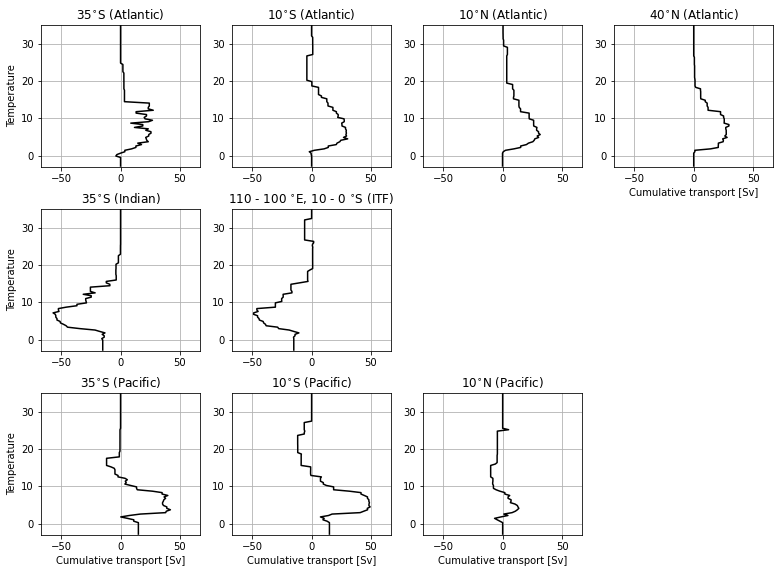

In [16]:
from scipy import stats

temp_bins = np.linspace(-3,35,100)
temp_mid = 0.5*(temp_bins[1:]+temp_bins[:-1])

temp_binned_transport = np.zeros((Basins.size, temp_mid.size))
temp_binned_transport[0,:] = stats.binned_statistic((T_1.reshape(9,128)[0,:]+T_1.reshape(9,128)[1,:])/2, southern_trans[0,:], bins = np.linspace(-3,35,100), statistic='sum').statistic
temp_binned_transport[1,:] = stats.binned_statistic((T_1.reshape(9,128)[1,:]+T_1.reshape(9,128)[2,:])/2, southern_trans[1,:], bins = np.linspace(-3,35,100), statistic='sum').statistic
temp_binned_transport[2,:] = stats.binned_statistic((T_1.reshape(9,128)[2,:]+T_1.reshape(9,128)[3,:])/2, southern_trans[2,:], bins = np.linspace(-3,35,100), statistic='sum').statistic
temp_binned_transport[3,:] = stats.binned_statistic((T_1.reshape(9,128)[3,:]+T_1.reshape(9,128)[8,:])/2, southern_trans[3,:], bins = np.linspace(-3,35,100), statistic='sum').statistic
temp_binned_transport[4,:] = stats.binned_statistic((T_1.reshape(9,128)[4,:]+T_1.reshape(9,128)[8,:])/2, southern_trans[4,:], bins = np.linspace(-3,35,100), statistic='sum').statistic
temp_binned_transport[5,:] = stats.binned_statistic((T_1.reshape(9,128)[4,:]+T_1.reshape(9,128)[6,:])/2, southern_trans[5,:], bins = np.linspace(-3,35,100), statistic='sum').statistic
temp_binned_transport[6,:] = stats.binned_statistic((T_1.reshape(9,128)[5,:]+T_1.reshape(9,128)[8,:])/2, southern_trans[6,:], bins = np.linspace(-3,35,100), statistic='sum').statistic
temp_binned_transport[7,:] = stats.binned_statistic((T_1.reshape(9,128)[6,:]+T_1.reshape(9,128)[5,:])/2, southern_trans[7,:], bins = np.linspace(-3,35,100), statistic='sum').statistic
temp_binned_transport[8,:] = stats.binned_statistic((T_1.reshape(9,128)[7,:]+T_1.reshape(9,128)[6,:])/2, southern_trans[8,:], bins = np.linspace(-3,35,100), statistic='sum').statistic

fig  = plt.figure(1, figsize = (17.5*0.75, 12.5*0.75))
gs = gridspec.GridSpec(3,4)
gs.update(wspace = 0.2, hspace=0.3)

ax1, ax2, ax3, ax4 = plt.subplot(gs[0,0]), \
           plt.subplot(gs[0,1]), \
           plt.subplot(gs[0,2]) , \
           plt.subplot(gs[0,3])

ax5, ax6 = plt.subplot(gs[1,0]), \
           plt.subplot(gs[1,1])

ax7, ax8,ax9 = plt.subplot(gs[2,0]), \
           plt.subplot(gs[2,1]), \
            plt.subplot(gs[2,2])

ax1.plot(np.cumsum((temp_binned_transport[3,:])[::-1])[::-1],temp_mid, '-k')
ax1.set_title(section_names[3])
ax1.set_ylim(-3,35)
ax1.set_xlim(-67,67)

ax2.plot(np.cumsum((temp_binned_transport[2,:])[::-1])[::-1],temp_mid, '-k')
ax2.set_title(section_names[2])
ax2.set_ylim(-3,35)
ax2.set_xlim(-67,67)

ax3.plot(np.cumsum((temp_binned_transport[1,:])[::-1])[::-1],temp_mid, '-k')
# ax3.vlines(mean_MOC_RAPID, -3,35, color='black', linestyle='dashed')
ax3.set_title(section_names[1])
ax3.set_ylim(-3,35)
ax3.set_xlim(-67,67)

ax4.plot(np.cumsum((temp_binned_transport[0,:])[::-1])[::-1],temp_mid, '-k')
# ax4.vlines(mean_MOC_RAPID, -3,35, color='black', linestyle='dashed')
ax4.set_title(section_names[0])
ax4.set_ylim(-3,35)
ax4.set_xlim(-67,67)
ax4.set_xlabel('Cumulative transport [Sv]')

ax5.plot(np.cumsum((temp_binned_transport[4,:])[::-1])[::-1],temp_mid, '-k')
ax5.set_title(section_names[4])
ax5.set_ylim(-3,35)
ax5.set_xlim(-67,67)

ax6.plot(np.cumsum((temp_binned_transport[5,:])[::-1])[::-1],temp_mid, '-k')
ax6.set_title(section_names[5])
ax6.set_ylim(-3,35)
ax6.set_xlim(-67,67)

ax7.plot(np.cumsum((temp_binned_transport[6,:])[::-1])[::-1],temp_mid, '-k')
ax7.set_title(section_names[6])
ax7.set_ylim(-3,35)
ax7.set_xlim(-67,67)
ax7.set_xlabel('Cumulative transport [Sv]')

ax8.plot(np.cumsum((temp_binned_transport[7,:])[::-1])[::-1],temp_mid, '-k')
ax8.set_title(section_names[7])
ax8.set_ylim(-3,35)
ax8.set_xlim(-67,67)
ax8.set_xlabel('Cumulative transport [Sv]')

ax9.plot(np.cumsum((temp_binned_transport[8,:])[::-1])[::-1],temp_mid, '-k')
ax9.set_title(section_names[8])
ax9.set_ylim(-3,35)
ax9.set_xlim(-67,67)
ax9.set_xlabel('Cumulative transport [Sv]')

ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()
ax5.grid()
ax6.grid()
ax7.grid()
ax8.grid()
ax9.grid()

ax1.set_ylabel('Temperature')
ax5.set_ylabel('Temperature')
ax7.set_ylabel('Temperature')

if SF:
    plt.savefig('Figures/Section_transports_Temp_space_knownSF.png', bbox_inches='tight', dpi=300)
else:
    plt.savefig('Figures/Section_transports_Temp_space_freerun.png', bbox_inches='tight', dpi=300)

plt.show()

In [15]:
# if Opt_twice:
#     '''constraint = [G@Q = V2*C2 - G@C2]
#         cost = cp.sum_squares( Q * volume/area )

#         where C1 is the initial and C2 is the final tracer concentrations.'''
#     result = MTM.optimise(tracers, volumes, constraints, weights)

#     g_ij = result['g_ij'] ## An [N x N] matrix of transports between WMs
#     Mixing = result['Mixing'] ## An [M x N] matrix of dtracer mixing for each WM
#     Adjustment = result['Adjustment'] ## An [M x N] matrix of dtracer adjustment for each WM

In [16]:
## Break down the Mixing and Adjustment matrices into their constituent tracers
dT_mixing = Mixing[1,:]
dS_mixing = Mixing[0,:]
dS_adj = Adjustment[0,:]
dT_adj = Adjustment[1,:]

----------
## E) Save Output 

In [35]:
da_dT_mixing = xr.DataArray(data = dT_mixing, dims = ["WM_number"],
                           coords=dict(WM_number = np.arange(0,N)),
                        attrs=dict(description="Temperature Mixing", units="\Delta K", variable_id="EN4 Tmix"))
da_dS_mixing = xr.DataArray(data = dS_mixing, dims = ["WM_number"],
                           coords=dict(WM_number = np.arange(0,N)),
                        attrs=dict(description="Salinity Mixing", units="\Delta g/kg", variable_id="EN4 Smix"))
da_dT_adjustment = xr.DataArray(data = dT_adj, dims = ["WM_number"],
                           coords=dict(WM_number = np.arange(0,N)),
                        attrs=dict(description="Temperature Adjustment", units="\Delta K", variable_id="EN4 Tadj"))
da_dS_adjustment = xr.DataArray(data = dS_adj, dims = ["WM_number"],
                           coords=dict(WM_number = np.arange(0,N)),
                        attrs=dict(description="Salinity Adjustment", units="\Delta g/kg", variable_id="EN4 Sadj"))
da_gij = xr.DataArray(data = g_ij*volnorming, dims = ["WM_initial", "WM_final"],
                           coords=dict(WM_initial = np.arange(0,N), WM_final = np.arange(0,N)),
                        attrs=dict(description="Volume transport", units="m^3", variable_id="EN4 Gij"))

## Create xarray DataSet that will hold all these DataArrays
ds_BSP = xr.Dataset()
ds_BSP['dT_mixing'] = da_dT_mixing
ds_BSP['dS_mixing'] = da_dS_mixing
ds_BSP['dT_adjustment'] = da_dT_adjustment
ds_BSP['dS_adjustment'] = da_dS_adjustment
ds_BSP['gij'] = da_gij

if SF:
   ds_BSP.to_netcdf('Optimisation_results/Optimal_result_EN4_SF.nc', mode='w')
else:
   ds_BSP.to_netcdf('Optimisation_results/Optimal_result_EN4.nc', mode='w')